# Libraries

In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import cv2 as cv

In [3]:
subfolder_path = Path.cwd()
notebooks_path = subfolder_path.parent
repo_path = notebooks_path.parent
os.chdir(str(subfolder_path))
#print current working directory
print(f'Current folder is: {os.getcwd()}\n')
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent.parent)) if sys.path[0] != str(thispath.parent.parent) else None

#Import paths and patients classes
from notebooks.info import path_label, patient

Current folder is: /home/ricardino/Documents/MAIA/tercer_semestre/Extra_activities/INCan/Added_value_feature_uncertainty/notebooks/budget



# Functions

# IMP

## Visualize

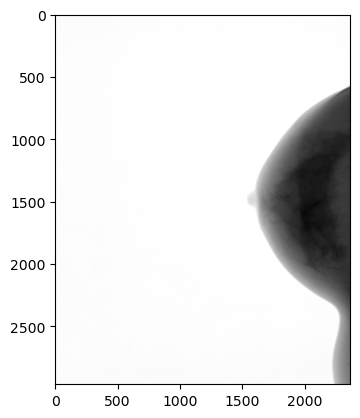

In [10]:
info = path_label()
pat = patient(info, 0)
im = pat.im_sitk('CMC', 't1')
im = sitk.GetArrayFromImage(im)
plt.imshow(im, cmap='gray')

/tmp/ipykernel_138528/4144681970.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


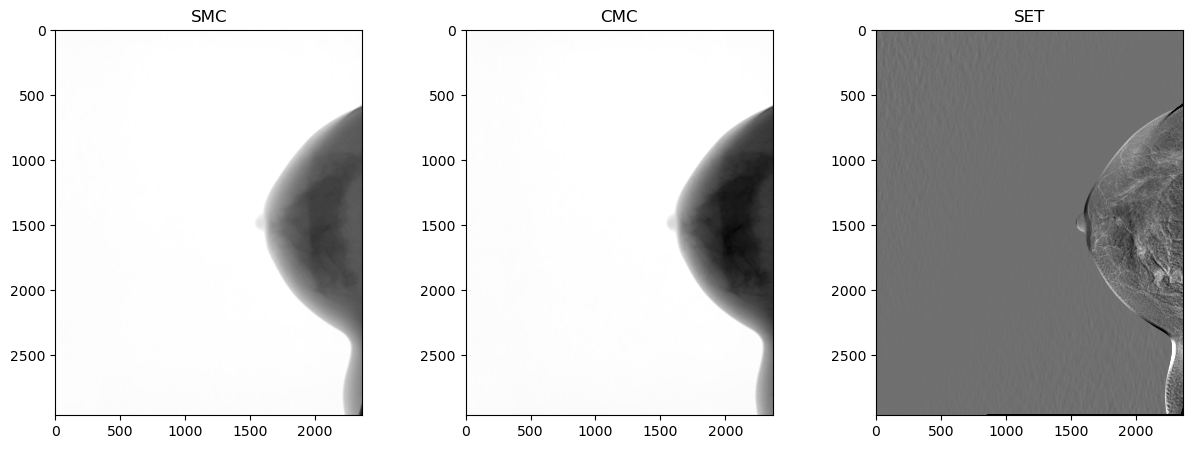

In [9]:
info = path_label()
i = 0
pat = patient(info, i)
# visualize image with SMC, image at time 1 and SET.
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_title('SMC')
axs[0].imshow(pat.im_array(sequence='SMC'), cmap='gray')
axs[1].set_title('CMC')
axs[1].imshow(pat.im_array(sequence='CMC'), cmap='gray')
axs[2].set_title('SET')
axs[2].imshow(np.fliplr(pat.im_array(sequence='SET')), vmin = 32671, vmax =32893, cmap='gray')
fig.show()

## Check histograms

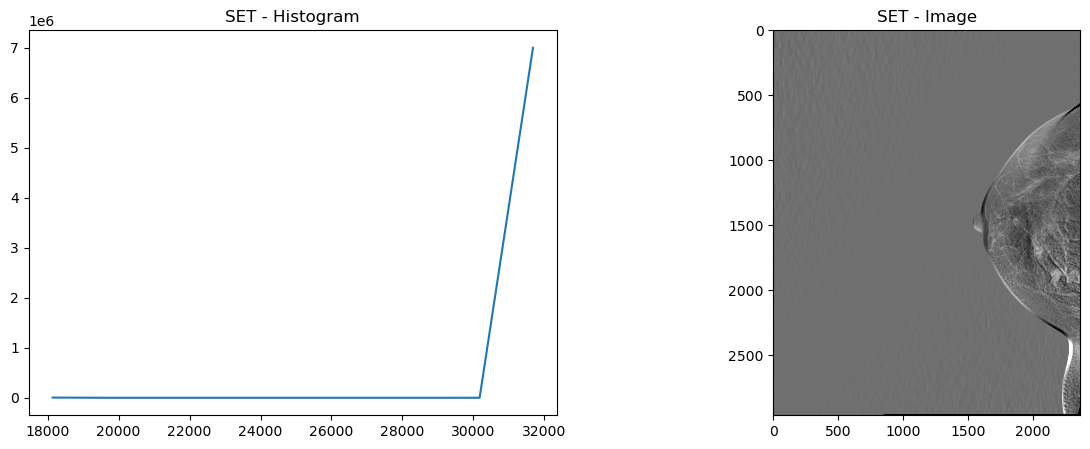

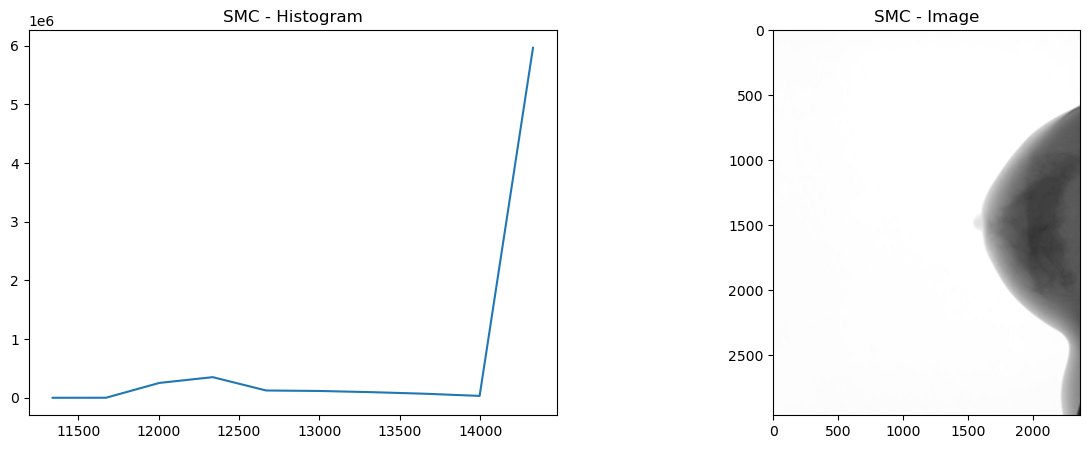

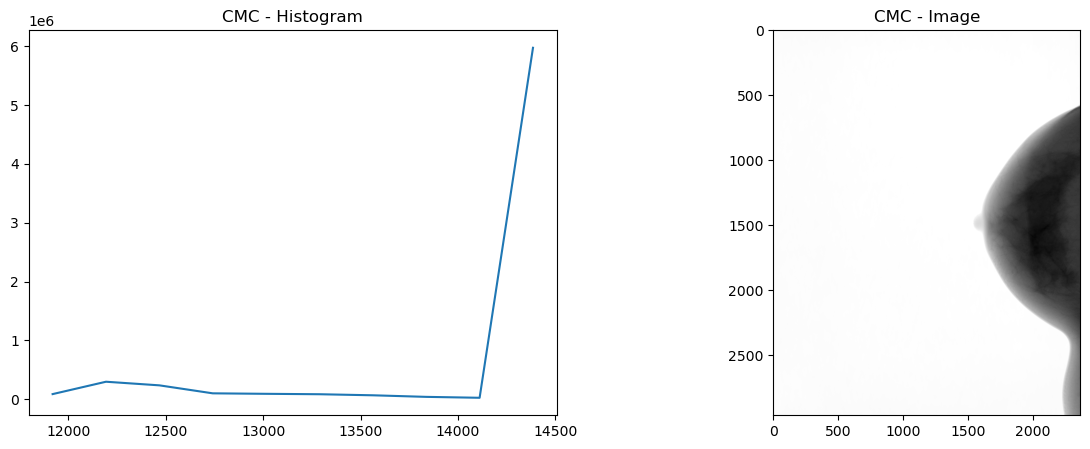

In [13]:
# We check the histograms of each image sequence
for seq in ['SET','SMC', 'CMC']:
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    axs[0].set_title(f'{seq} - Histogram')
    hist = np.histogram(pat.im_array(sequence=seq))
    axs[0].plot(hist[1][:-1], hist[0])
    axs[1].set_title(f'{seq} - Image')
    axs[1].imshow(pat.im_array(sequence=seq), cmap='gray') if seq != 'SET' else axs[1].imshow(np.fliplr(pat.im_array(sequence=seq)), vmin = 32671, vmax =32893, cmap='gray')

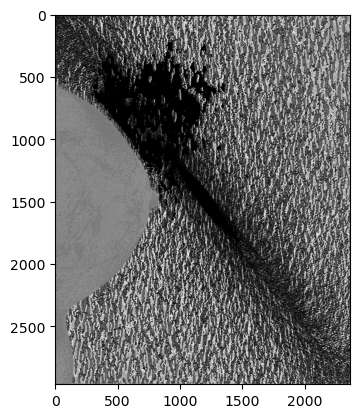

In [8]:
img = getArrayfromPath(str(repo_path) + '/' + info.im_path(sequence='SET')[0])
equ = cv.equalizeHist(img.astype('uint8'))
plt.imshow(equ, cmap='gray')